In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
from utils.datastore import *
from utils.utils import set_seed
import pandas as pd
import numpy as np

set_seed()  # for code reproducibility

In [3]:
ds = DataStore()
D1, D2, D3 = ds.build_datasets()
classes = D3["label"].unique().tolist()
n_label = len(classes)

### Data exploration

In [4]:
from IPython.display import display, Markdown


def display_missing_values(df):
    """
    This function calculates the percentage of missing values in each column of a
    Pandas DataFrame and displays the results in descending order.

    :return: None
    """

    missing_values = df.isnull().sum() / len(df) * 100
    missing_values = missing_values.sort_values(ascending=False)
    missing_values.rename("% Missing Values", inplace=True)
    display(Markdown(missing_values.to_markdown()))
    del missing_values


def unique_values_table(df, uv=3):
    """
    Print a markdown table
    with the col, the number of unique values and the unique values
    list if there are less than 3 unique values (uv) by defalt.

    :param uv: int
    :return: None
    """
    from IPython.display import display, Markdown

    md_table_str = "|Column Name|Unique Values||\n|---|---|---|\n"
    for col_name, unique_values in df.nunique().items():
        if unique_values > uv:
            md_table_str += "|{}|{}|\n".format(col_name, unique_values)
        else:
            md_unique_str = " ".join(
                [
                    f"{name}: {value*100:.2f}\%"
                    for name, value in df[col_name].value_counts(normalize=True).items()
                ]
            )

            md_table_str += "|{}|{}|{}\n".format(col_name, unique_values, md_unique_str)
    display(Markdown(md_table_str))

In [5]:
D3.head()

,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,label
0,0.0,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333334,7.666666,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,BRICKFACE
1,0.0,0.0,0.333333,0.266667,0.500000,0.077778,6.666666,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,BRICKFACE
2,0.0,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333334,3.333333,-7.666666,7.555555,0.532628,BRICKFACE
3,0.0,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,BRICKFACE
4,0.0,0.0,0.722222,0.374074,0.888889,0.429629,6.037037,7.000000,7.666666,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,BRICKFACE


In [6]:
print("Dataset 1")
display_missing_values(D1)

print("Dataset 2")
display_missing_values(D2)

print("Dataset 3")
display_missing_values(D3)

Dataset 1


|                      |   % Missing Values |
|:---------------------|-------------------:|
| SHORT-LINE-DENSITY-5 |                  0 |
| SHORT-LINE-DENSITY-2 |                  0 |
| VEDGE-MEAN           |                  0 |
| VEDGE-SD             |                  0 |
| HEDGE-MEAN           |                  0 |
| label                |                  0 |

Dataset 2


|                 |   % Missing Values |
|:----------------|-------------------:|
| INTENSITY-MEAN  |                  0 |
| RAWRED-MEAN     |                  0 |
| RAWBLUE-MEAN    |                  0 |
| RAWGREEN-MEAN   |                  0 |
| EXRED-MEAN      |                  0 |
| EXBLUE-MEAN     |                  0 |
| EXGREEN-MEAN    |                  0 |
| VALUE-MEAN      |                  0 |
| SATURATION-MEAN |                  0 |
| label           |                  0 |

Dataset 3


|                      |   % Missing Values |
|:---------------------|-------------------:|
| SHORT-LINE-DENSITY-5 |                  0 |
| SHORT-LINE-DENSITY-2 |                  0 |
| VEDGE-MEAN           |                  0 |
| VEDGE-SD             |                  0 |
| HEDGE-MEAN           |                  0 |
| HEDGE-SD             |                  0 |
| INTENSITY-MEAN       |                  0 |
| RAWRED-MEAN          |                  0 |
| RAWBLUE-MEAN         |                  0 |
| RAWGREEN-MEAN        |                  0 |
| EXRED-MEAN           |                  0 |
| EXBLUE-MEAN          |                  0 |
| EXGREEN-MEAN         |                  0 |
| VALUE-MEAN           |                  0 |
| SATURATION-MEAN      |                  0 |
| label                |                  0 |

In [7]:
print("Dataset 1")
unique_values_table(D1[["label"]], n_label)

print("Dataset 2")
unique_values_table(D2[["label"]], n_label)

print("Dataset 3")
unique_values_table(D3[["label"]], n_label)

Dataset 1


|Column Name|Unique Values||
|---|---|---|
|label|7|BRICKFACE: 14.30\% SKY: 14.30\% FOLIAGE: 14.30\% WINDOW: 14.30\% PATH: 14.30\% CEMENT: 14.25\% GRASS: 14.25\%


Dataset 2


|Column Name|Unique Values||
|---|---|---|
|label|7|BRICKFACE: 14.30\% SKY: 14.30\% FOLIAGE: 14.30\% WINDOW: 14.30\% PATH: 14.30\% CEMENT: 14.25\% GRASS: 14.25\%


Dataset 3


|Column Name|Unique Values||
|---|---|---|
|label|7|BRICKFACE: 14.30\% SKY: 14.30\% FOLIAGE: 14.30\% WINDOW: 14.30\% PATH: 14.30\% CEMENT: 14.25\% GRASS: 14.25\%


<AxesSubplot:>

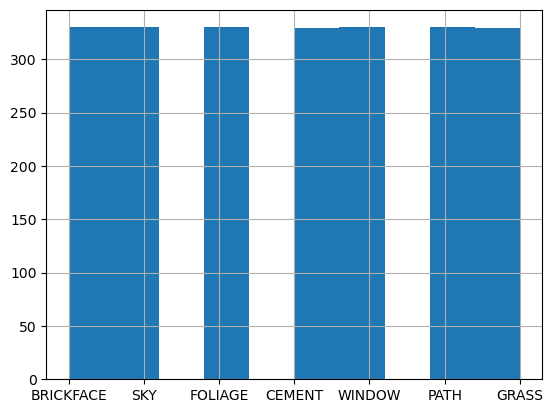

In [8]:
D1["label"].hist()

### Load models

In [9]:
# Gaussian NB
from sklearn.naive_bayes import GaussianNB

# Baysean Nearest Neighbor
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestNeighbors


class BayesianNearestNeighbors(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.classes_, y_indices = np.unique(y, return_inverse=True)
        self.models_ = []

        for i in range(len(self.classes_)):
            nn = NearestNeighbors(n_neighbors=self.n_neighbors)
            nn.fit(X[y_indices == i])
            self.models_.append(nn)

        return self

    def predict_proba(self, X):
        probs = np.zeros((X.shape[0], len(self.classes_)))

        for i, model in enumerate(self.models_):
            dist, _ = model.kneighbors(X)
            probs[:, i] = np.mean(np.exp(-(dist**2) / 2), axis=1)

        return probs / probs.sum(axis=1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]


# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Parzen
from sklearn.neighbors import KernelDensity
from sklearn.base import BaseEstimator, ClassifierMixin


class ParzenWindowClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, bandwidth=1.0, kernel="gaussian", metric="euclidean"):
        self.bandwidth = bandwidth
        self.kernel = kernel
        self.metric = metric

    def fit(self, X, y):
        self.classes_, y_indices = np.unique(y, return_inverse=True)
        self.models_ = []

        for i in range(len(self.classes_)):
            kde = KernelDensity(
                bandwidth=self.bandwidth, kernel=self.kernel, metric=self.metric
            )
            kde.fit(X[y_indices == i])
            self.models_.append(kde)

        return self

    def predict_proba(self, X):
        log_probs = np.array([model.score_samples(X) for model in self.models_]).T
        probs = np.exp(log_probs)
        return probs / probs.sum(axis=1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

### Train models

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def stratified_cross_val(model_list, data, n_folds=30, n_splits=10):
    model_results = {type(model).__name__: [] for model in model_list}

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    X, y = data.iloc[:, :-1], data.iloc[:, -1]

    for model in model_list:
        pipeline = Pipeline([
            #("scaler", StandardScaler()), # uncomment to scale data
            ("model", model)
        ])

        for _ in range(n_folds):
            iter_scores = cross_validate(
                pipeline, 
                X,
                y,
                cv=cv,
                scoring={
                    "f1_score": "f1_macro",
                    "precision_score": "precision_macro",
                    "accuracy_score": "accuracy",
                    "recall_score": "recall_macro",
                },
                n_jobs=-1,
            )
            model_results[type(model).__name__].append(iter_scores)

    return model_results



def model_results_to_df(model_results):
    res_final = pd.DataFrame(
        columns=[
            "fit_time",
            "score_time",
            "test_f1_score",
            "test_precision_score",
            "test_accuracy_score",
            "test_recall_score",
            "split",
            "model",
        ]
    )

    for model in model_results.keys():
        for i in range(len(model_results[model])):
            _res = pd.DataFrame(
                model_results[model][i].values(),
                index=model_results[model][i].keys(),
            ).T
            _res["split"] = i
            _res["model"] = model
            res_final = pd.concat([res_final, _res])

    return res_final

In [11]:
model_list = [
    GaussianNB(),
    ParzenWindowClassifier(kernel="gaussian"),
    LogisticRegression(),
    BayesianNearestNeighbors(n_neighbors=1),
]

In [12]:
results_df = model_results_to_df(stratified_cross_val(model_list, D3))
results_df

,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score,split,model
0,0.005998,0.011003,0.661889,0.704257,0.688312,0.688312,0,GaussianNB
1,0.005000,0.011006,0.700054,0.735001,0.722944,0.722944,0,GaussianNB
2,0.006004,0.009999,0.692586,0.734551,0.718615,0.718615,0,GaussianNB
3,0.006000,0.008999,0.729231,0.751150,0.748918,0.748918,0,GaussianNB
4,0.006002,0.009000,0.628484,0.676672,0.658009,0.658009,0,GaussianNB
...,...,...,...,...,...,...,...,...
5,0.014000,0.022002,0.930174,0.933006,0.930736,0.930736,29,BayesianNearestNeighbors
6,0.014001,0.022002,0.898193,0.904268,0.900433,0.900433,29,BayesianNearestNeighbors
7,0.013999,0.021003,0.892134,0.899117,0.896104,0.896104,29,BayesianNearestNeighbors
8,0.013001,0.020001,0.894640,0.898161,0.895652,0.896104,29,BayesianNearestNeighbors


In [13]:
results_df.groupby("model").mean()

,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score,split
model,,,,,,,
BayesianNearestNeighbors,0.011660,0.022779,0.906352,0.910846,0.907698,0.907687,14.5
GaussianNB,0.004358,0.007897,0.672247,0.716814,0.700350,0.700322,14.5
LogisticRegression,0.070747,0.007223,0.861096,0.866000,0.862810,0.862746,14.5
ParzenWindowClassifier,0.010917,0.039806,0.918013,0.920514,0.918851,0.918831,14.5


### Statistical Tests

In [14]:
import numpy as np
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman


def perform_friedman_nemenyi_tests(df):
    metrics = [
        "test_f1_score",
        "test_precision_score",
        "test_accuracy_score",
        "test_recall_score",
    ]
    models = df["model"].unique()
    folds = df["split"].unique()

    results = {}
    for metric in metrics:
        results[metric] = np.zeros((len(models), len(folds)))
        for i, model in enumerate(models):
            for j, fold in enumerate(folds):
                results[metric][i, j] = df.loc[
                    (df["model"] == model) & (df["split"] == fold)
                ][metric].values[0]

    # Friedman test
    for metric in metrics:
        stat, p_value = friedmanchisquare(*results[metric])
        print(f"{metric}: Friedman Chi Square = {stat:.3f}, p-value = {p_value:.3f}")
        if p_value < 0.05:
            print("Significant difference between models\n")
        else:
            print("No significant difference between models")

    # Nemenyi test
    for metric in metrics:
        posthoc = posthoc_nemenyi_friedman(results[metric].T)
        print(f"\nNemenyi PostHoc Test for {metric}:")
        print(posthoc)


perform_friedman_nemenyi_tests(results_df)

test_f1_score: Friedman Chi Square = 76.360, p-value = 0.000
Significant difference between models

test_precision_score: Friedman Chi Square = 76.680, p-value = 0.000
Significant difference between models

test_accuracy_score: Friedman Chi Square = 77.909, p-value = 0.000
Significant difference between models

test_recall_score: Friedman Chi Square = 77.930, p-value = 0.000
Significant difference between models


Nemenyi PostHoc Test for test_f1_score:
          0         1         2         3
0  1.000000  0.001000  0.005345  0.001000
1  0.001000  1.000000  0.001000  0.892239
2  0.005345  0.001000  1.000000  0.001236
3  0.001000  0.892239  0.001236  1.000000

Nemenyi PostHoc Test for test_precision_score:
          0        1         2         3
0  1.000000  0.00100  0.005345  0.001000
1  0.001000  1.00000  0.001000  0.779980
2  0.005345  0.00100  1.000000  0.001808
3  0.001000  0.77998  0.001808  1.000000

Nemenyi PostHoc Test for test_accuracy_score:
          0         1         2 

### Model tuning

In [15]:
import optuna
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

optuna.logging.set_verbosity(optuna.logging.CRITICAL)

import os

# Avoid use n_jobs=-1 in each call of sklearn model
os.environ["JOBLIB_MULTIPROCESSING"] = "true"


def objective(trial, model_name, data):
    X_train, X_test, y_train, y_test = data

    if model_name == "GaussianNB":
        var_smoothing = trial.suggest_float("var_smoothing", 1e-10, 1e-1)
        model = GaussianNB(var_smoothing=var_smoothing)

    elif model_name == "ParzenWindowClassifier":
        bandwidth = trial.suggest_float("bandwidth", 1e-10, 1e-1)
        kernel = trial.suggest_categorical(
            "kernel",
            ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"],
        )
        model = ParzenWindowClassifier(bandwidth=bandwidth, kernel=kernel)

    elif model_name == "LogisticRegression":
        # With fixed lbfgs solver, only l2 and none are available for penalty
        penalty = trial.suggest_categorical("penalty", ["l2", "none"])
        C = trial.suggest_float("C", 1e-10, 1e-1)
        model = LogisticRegression(C=C, penalty=penalty)

    elif model_name == "BayesianNearestNeighbors":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 15)
        model = BayesianNearestNeighbors(n_neighbors=n_neighbors)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred, average="macro")

In [16]:
datasets = [D1, D2, D3]
iteration = 1

models = [type(model).__name__ for model in model_list]
N_TRIALS = 10

results = {model: {i: "" for i in range(len(datasets))} for model in models}

for dataset in datasets:
    valid_ds = dataset.sample(frac=0.2, random_state=42)
    valid_split = train_test_split(
        valid_ds.iloc[:, :-1], valid_ds.iloc[:, -1], test_size=0.2, random_state=42
    )

    for model_name in models:
        search = lambda trial: objective(trial, model_name=model_name, data=valid_split)
        sampler = optuna.samplers.TPESampler(seed=42)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(search, n_trials=N_TRIALS)

        print(
            "to dataset %d with model %s the best parameter is:"
            % (iteration, model_name)
        )
        print(study.best_params)
        print("F1-score:%.3f" % study.best_value, "\n")

        results[model_name][iteration] = (study.best_params, study.best_value)

    iteration += 1

to dataset 1 with model GaussianNB the best parameter is:
{'var_smoothing': 0.01560186412864179}
F1-score:0.273 

to dataset 1 with model ParzenWindowClassifier the best parameter is:
{'bandwidth': 0.08661761459087591, 'kernel': 'exponential'}
F1-score:0.437 

to dataset 1 with model LogisticRegression the best parameter is:
{'penalty': 'l2', 'C': 0.018182496802527568}
F1-score:0.276 

to dataset 1 with model BayesianNearestNeighbors the best parameter is:
{'n_neighbors': 15}
F1-score:0.475 

to dataset 2 with model GaussianNB the best parameter is:
{'var_smoothing': 0.005808361311011585}
F1-score:0.680 

to dataset 2 with model ParzenWindowClassifier the best parameter is:
{'bandwidth': 0.013949386151254798, 'kernel': 'exponential'}
F1-score:0.839 

to dataset 2 with model LogisticRegression the best parameter is:
{'penalty': 'l2', 'C': 0.06118528951105266}
F1-score:0.764 

to dataset 2 with model BayesianNearestNeighbors the best parameter is:
{'n_neighbors': 6}
F1-score:0.851 

to d

In [17]:
results

{'GaussianNB': {0: '',
  1: ({'var_smoothing': 0.01560186412864179}, 0.27258521080275133),
  2: ({'var_smoothing': 0.005808361311011585}, 0.6795155309087199),
  3: ({'var_smoothing': 0.005808361311011585}, 0.6853165594510127)},
 'ParzenWindowClassifier': {0: '',
  1: ({'bandwidth': 0.08661761459087591, 'kernel': 'exponential'},
   0.4373390462904529),
  2: ({'bandwidth': 0.013949386151254798, 'kernel': 'exponential'},
   0.8391777677491963),
  3: ({'bandwidth': 0.08661761459087591, 'kernel': 'exponential'},
   0.8601551497792099)},
 'LogisticRegression': {0: '',
  1: ({'penalty': 'l2', 'C': 0.018182496802527568}, 0.2762471655328798),
  2: ({'penalty': 'l2', 'C': 0.06118528951105266}, 0.7636381162696952),
  3: ({'penalty': 'l2', 'C': 0.018182496802527568}, 0.8681232492997198)},
 'BayesianNearestNeighbors': {0: '',
  1: ({'n_neighbors': 15}, 0.47513027513027506),
  2: ({'n_neighbors': 6}, 0.8506516906516906),
  3: ({'n_neighbors': 6}, 0.8522412208126493)}}

### Train with tuned parameters

In [18]:
best_params = {
    model: results[model][3][0] for model in models
}

model_list = [
    GaussianNB(**best_params["GaussianNB"]),
    ParzenWindowClassifier(**best_params["ParzenWindowClassifier"]),
    LogisticRegression(**best_params["LogisticRegression"]),
    BayesianNearestNeighbors(**best_params["BayesianNearestNeighbors"]),
]

results_df1 = model_results_to_df(stratified_cross_val(model_list, D1))
results_df2 = model_results_to_df(stratified_cross_val(model_list, D2))
results_df3 = model_results_to_df(stratified_cross_val(model_list, D3))

In [19]:
# Display grouped results for each dataset

print('Results using only image shape features (Dataset 1):')
display(results_df1.groupby("model").mean().drop("split", axis=1))
print('Results using only color features (Dataset 2):')
display(results_df2.groupby("model").mean().drop("split", axis=1))
print('Results using both image shape and color features (Dataset 3):')
display(results_df3.groupby("model").mean().drop("split", axis=1))


Results using only image shape features (Dataset 1):


,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score
model,,,,,,
BayesianNearestNeighbors,0.010160,0.017459,0.427223,0.443730,0.438510,0.438434
GaussianNB,0.003890,0.007688,0.174863,0.306885,0.244411,0.244313
LogisticRegression,0.064814,0.006976,0.291709,0.330112,0.318951,0.318937
ParzenWindowClassifier,0.009343,0.034757,0.468759,0.494406,0.479621,0.479530


Results using only color features (Dataset 2):


,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score
model,,,,,,
BayesianNearestNeighbors,0.010626,0.019479,0.908575,0.912204,0.909377,0.909356
GaussianNB,0.003951,0.007497,0.614564,0.693065,0.648238,0.648238
LogisticRegression,0.063439,0.006886,0.786947,0.798002,0.801472,0.801308
ParzenWindowClassifier,0.009980,0.025190,0.912692,0.914676,0.912942,0.912907


Results using both image shape and color features (Dataset 3):


,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score
model,,,,,,
BayesianNearestNeighbors,0.011331,0.025416,0.912652,0.916528,0.913763,0.913750
GaussianNB,0.004185,0.007536,0.616117,0.672885,0.663810,0.663728
LogisticRegression,0.068726,0.007006,0.865229,0.871062,0.867198,0.867119
ParzenWindowClassifier,0.010679,0.035895,0.889048,0.892428,0.888748,0.888750


#### Statistical test for D1

In [20]:
perform_friedman_nemenyi_tests(results_df1)

test_f1_score: Friedman Chi Square = 86.760, p-value = 0.000
Significant difference between models

test_precision_score: Friedman Chi Square = 77.080, p-value = 0.000
Significant difference between models

test_accuracy_score: Friedman Chi Square = 86.579, p-value = 0.000
Significant difference between models

test_recall_score: Friedman Chi Square = 86.579, p-value = 0.000
Significant difference between models


Nemenyi PostHoc Test for test_f1_score:
          0         1         2         3
0  1.000000  0.001000  0.014361  0.001000
1  0.001000  1.000000  0.001000  0.077185
2  0.014361  0.001000  1.000000  0.005345
3  0.001000  0.077185  0.005345  1.000000

Nemenyi PostHoc Test for test_precision_score:
          0         1         2         3
0  1.000000  0.001000  0.667717  0.001000
1  0.001000  1.000000  0.001000  0.059946
2  0.667717  0.001000  1.000000  0.001000
3  0.001000  0.059946  0.001000  1.000000

Nemenyi PostHoc Test for test_accuracy_score:
          0         1      

#### Statistical test for D2

In [21]:
perform_friedman_nemenyi_tests(results_df2)

test_f1_score: Friedman Chi Square = 81.040, p-value = 0.000
Significant difference between models

test_precision_score: Friedman Chi Square = 79.840, p-value = 0.000
Significant difference between models

test_accuracy_score: Friedman Chi Square = 81.828, p-value = 0.000
Significant difference between models

test_recall_score: Friedman Chi Square = 81.828, p-value = 0.000
Significant difference between models


Nemenyi PostHoc Test for test_f1_score:
          0      1         2      3
0  1.000000  0.001  0.014361  0.001
1  0.001000  1.000  0.001000  0.900
2  0.014361  0.001  1.000000  0.001
3  0.001000  0.900  0.001000  1.000

Nemenyi PostHoc Test for test_precision_score:
          0      1         2      3
0  1.000000  0.001  0.026287  0.001
1  0.001000  1.000  0.001000  0.900
2  0.026287  0.001  1.000000  0.001
3  0.001000  0.900  0.001000  1.000

Nemenyi PostHoc Test for test_accuracy_score:
          0      1         2      3
0  1.000000  0.001  0.014361  0.001
1  0.001000  1.

#### Statistical test for D3

In [22]:
perform_friedman_nemenyi_tests(results_df3)

test_f1_score: Friedman Chi Square = 75.640, p-value = 0.000
Significant difference between models

test_precision_score: Friedman Chi Square = 73.960, p-value = 0.000
Significant difference between models

test_accuracy_score: Friedman Chi Square = 76.892, p-value = 0.000
Significant difference between models

test_recall_score: Friedman Chi Square = 76.892, p-value = 0.000
Significant difference between models


Nemenyi PostHoc Test for test_f1_score:
       0         1         2         3
0  1.000  0.001000  0.001000  0.001000
1  0.001  1.000000  0.323667  0.019536
2  0.001  0.323667  1.000000  0.001000
3  0.001  0.019536  0.001000  1.000000

Nemenyi PostHoc Test for test_precision_score:
       0         1         2        3
0  1.000  0.001000  0.001000  0.00100
1  0.001  1.000000  0.667717  0.00751
2  0.001  0.667717  1.000000  0.00100
3  0.001  0.007510  0.001000  1.00000

Nemenyi PostHoc Test for test_accuracy_score:
       0         1         2         3
0  1.000  0.001000  0.0